<a href="https://colab.research.google.com/github/azizdafi/Cloud-Cover-Detection/blob/main/Cloud_Cover_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project Name**    - Cloud Cover Detection



# **GitHub Link -**

[Github Link](https://github.com/azizdafi/Cloud-Cover-Detection)

# **Problem Statement**


**Create a Vision Transformer (ViT) based model capable of accurately identifying and effectively masking clouds in multispectral satellite imagery, per pixel. These models should significantly elevate the quality of input data for Earth surface analysis, specifically benefiting analytical tasks reliant on accurate cloud removal and detection.**

Link to the dataset in multiple forms, as well as reference paper :
https://www.kaggle.com/datasets/hmendonca/cloud-cover-detection

# ***Let's Begin !***



## ***1. Understanding Kaggle Data***

### Required installations

In [1]:
# Installing required Libraries
from IPython.display import clear_output
# clear_output()
!pip install -q kaggle
clear_output()
!pip install rasterio
clear_output()
!pip install xarray-spatial
clear_output()
!pip install tqdm


clear_output()

### Import Libraries

In [64]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import missingno as msno



#setting font size throughout the notebook
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(18, 6))

# libraries for images processing and eda
import glob
import rasterio
from PIL import Image
import xarray as xr
import xarray
from google.colab.patches import cv2_imshow
import xrspatial.multispectral as ms
from pathlib import Path


import zipfile
from zipfile import *
from tqdm import tqdm

clear_output()

from pathlib import Path

<Figure size 1800x600 with 0 Axes>

### Dataset Loading

In [3]:
# the below credentails are set to exire on 8th oct 2023, create your own credentails to execute the file.
# append the credentails content below within single quotes
json_credentials = '{"username":"azizdafi","key":"f9f762436373459b5feb81c467047ca5"}'

# create file kaggle.json and add the credentials to it.
cmd = """text_file = open("kaggle.json", "w+");text_file.write(json_credentials);text_file.close()"""
exec(cmd)
print("file created sucesfully")

# Load Dataset
! mkdir ~/.kaggle
! mv kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
print("json file moved to the destination folder")

# import the dataset from kaggel
!kaggle datasets download -d hmendonca/cloud-cover-detection
print("Data downloaded sucesfully \nextracting the data from downloaded zip file")

# unzip the downloaded file
# !unzip -q cloud-cover-detection.zip
target_path = '/content/'
with zipfile.ZipFile('cloud-cover-detection.zip') as zf:
  for member in tqdm(zf.infolist(), desc='Extracting '):
    try:
      zf.extract(member, target_path)
    except zipfile.error as e:
      pass
print("Unzip sucessfull, deleting the zip file for memory optimization")

# remove the downloaded zip file to have optimized disc space
!rm -rf cloud-cover-detection.zip
print("zip file deleted sucessfully")

file created sucesfully
json file moved to the destination folder
100% 16.2G/16.2G [02:57<00:00, 83.1MB/s]
100% 16.2G/16.2G [02:57<00:00, 98.1MB/s]
Data downloaded sucesfully 
extracting the data from downloaded zip file


Extracting : 100%|██████████| 58741/58741 [05:22<00:00, 181.90it/s]


Unzip sucessfull, deleting the zip file for memory optimization
zip file deleted sucessfully


In [4]:
# !unzip -q cloud-cover-detection.zip
# print("Unzip sucessfull, deleting  the zip file for memory optimization")

### Dataset First View

In [5]:
# importing Train_meta file and parsing dates
# df = pd.read_csv("/content/train_metadata.csv")
df = pd.read_csv("/content/train_metadata.csv", parse_dates = ['datetime'])

df.head(10)

chip_id  location                  datetime                   cloudpath
0    adwp  Chifunfu 2020-04-29 08:20:47+00:00  az://./train_features/adwp
1    adwu  Chifunfu 2020-04-29 08:20:47+00:00  az://./train_features/adwu
2    adwz  Chifunfu 2020-04-29 08:20:47+00:00  az://./train_features/adwz
3    adxp  Chifunfu 2020-04-29 08:20:47+00:00  az://./train_features/adxp
4    aeaj  Chifunfu 2020-04-29 08:20:47+00:00  az://./train_features/aeaj
5    aeap  Chifunfu 2020-04-29 08:20:47+00:00  az://./train_features/aeap
6    aebi  Chifunfu 2020-04-29 08:20:47+00:00  az://./train_features/aebi
7    aebu  Chifunfu 2020-04-29 08:20:47+00:00  az://./train_features/aebu
8    aeej  Chifunfu 2020-04-29 08:20:47+00:00  az://./train_features/aeej
9    aeey  Chifunfu 2020-04-29 08:20:47+00:00  az://./train_features/aeey

### Dataset Rows & Columns count

In [6]:
# Dataset Rows & Columns count
x = df.shape
print(f'the meta file has {x[0]} rows and {x[1]} columns')

the meta file has 11748 rows and 4 columns


### Dataset Information

In [7]:
# Dataset Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11748 entries, 0 to 11747
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   chip_id    11748 non-null  object             
 1   location   11748 non-null  object             
 2   datetime   11748 non-null  datetime64[ns, UTC]
 3   cloudpath  11748 non-null  object             
dtypes: datetime64[ns, UTC](1), object(3)
memory usage: 367.2+ KB


#### Duplicate Values

In [8]:
# Dataset Duplicate Value Count
dup = df.duplicated().sum()
print(f'number of duplicated rows are {dup}')

number of duplicated rows are 0


#### Missing Values/Null Values

In [9]:
# Missing Values/Null Values Count
missing_values = df.isna().sum()
print(missing_values)

chip_id      0
location     0
datetime     0
cloudpath    0
dtype: int64


## ***2. Understanding Your Variables***

In [10]:
# Dataset Columns
print(df.columns)

Index(['chip_id', 'location', 'datetime', 'cloudpath'], dtype='object')


The metafile has   
chip_id that is unique for every row.  
location: the area/city of the data captured  
datetime: the time at wich it was recorded  
cloudpath: is the path of azure data location

In [11]:
# Dataset Describe
df.describe(include='all')

<ipython-input-11-1fb2dbb7a3f1>:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe(include='all')


chip_id  location                   datetime  \
count    11748     11748                      11748   
unique   11748        81                         91   
top       adwp  Chifunfu  2020-09-06 15:02:37+00:00   
freq         1       341                        261   
first      NaN       NaN  2018-03-07 08:46:02+00:00   
last       NaN       NaN  2020-09-14 08:28:49+00:00   

                         cloudpath  
count                        11748  
unique                       11748  
top     az://./train_features/adwp  
freq                             1  
first                          NaN  
last                           NaN

### Check Unique Values for each variable.

In [12]:
# Check Unique Values for each variable and listing values whose count is less than 25
for column in df.columns:
  res = len(df[column].unique())
  print(f"The number of unique variables in {column} column are: {res}")

The number of unique variables in chip_id column are: 11748
The number of unique variables in location column are: 81
The number of unique variables in datetime column are: 91
The number of unique variables in cloudpath column are: 11748


## 3. ***Data Wrangling***

### Data Wrangling Code

from the give datetime column, I have extracted date, hour, year, month for EDA purpose to understand the pattern in data collection.

In [13]:
# generating features from the meta data for eda
df['date'] = df['datetime'].dt.date
df['hour'] = df['datetime'].dt.hour
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month

the below code is writen to map all the relavant bands file and paths and append un the data frame for better understanding and for further development of the model.

image paths are appended based on pattern of folder structure

In [14]:
# creating paths to the different bands of images
img_bands = ["B02", "B03", "B04", "B08"]

def add_paths(df, feature_dir, label_dir=None, bands=img_bands):
  "this function generates paths to the bands of file and adds to the dataframe"
  for band in bands:
    paths = []
    for x in df["chip_id"]:
      paths.append(f"{feature_dir}/{x}/{band}.tif")
    df[f"{band}_path"] = paths

    if label_dir is not None:
      label_paths = []
      for x in df["chip_id"]:
        label_paths.append(f"{label_dir}/{x}.tif")
      df["label_path"] = label_paths

add_paths(df, "/content/data/train_features", "/content/data/train_labels", img_bands)
df.head()


chip_id  location                  datetime                   cloudpath  \
0    adwp  Chifunfu 2020-04-29 08:20:47+00:00  az://./train_features/adwp   
1    adwu  Chifunfu 2020-04-29 08:20:47+00:00  az://./train_features/adwu   
2    adwz  Chifunfu 2020-04-29 08:20:47+00:00  az://./train_features/adwz   
3    adxp  Chifunfu 2020-04-29 08:20:47+00:00  az://./train_features/adxp   
4    aeaj  Chifunfu 2020-04-29 08:20:47+00:00  az://./train_features/aeaj   

         date  hour  year  month                                   B02_path  \
0  2020-04-29     8  2020      4  /content/data/train_features/adwp/B02.tif   
1  2020-04-29     8  2020      4  /content/data/train_features/adwu/B02.tif   
2  2020-04-29     8  2020      4  /content/data/train_features/adwz/B02.tif   
3  2020-04-29     8  2020      4  /content/data/train_features/adxp/B02.tif   
4  2020-04-29     8  2020      4  /content/data/train_features/aeaj/B02.tif   

                            label_path  \
0  /content/data/train_labels/adwp.tif   
1  /content/data/train_labels/adwu.tif   
2  /content/data/train_labels/adwz.tif   
3  /content/data/train_labels/adxp.tif   
4  /content/data/train_labels/aeaj.tif   

                                    B03_path  \
0  /content/data/train_features/adwp/B03.tif   
1  /content/data/train_features/adwu/B03.tif   
2  /content/data/train_features/adwz/B03.tif   
3  /content/data/train_features/adxp/B03.tif   
4  /content/data/train_features/aeaj/B03.tif   

                                    B04_path  \
0  /content/data/train_features/adwp/B04.tif   
1  /content/data/train_features/adwu/B04.tif   
2  /content/data/train_features/adwz/B04.tif   
3  /content/data/train_features/adxp/B04.tif   
4  /content/data/train_features/aeaj/B04.tif   

                                    B08_path  
0  /content/data/train_features/adwp/B08.tif  
1  /content/data/train_features/adwu/B08.tif  
2  /content/data/train_features/adwz/B08.tif  
3  /content/data/train_features/adxp/B08.tif  
4  /content/data/train_features/aeaj/B08.tif

In [15]:
# dropping cloud path column
# df = df.drop('cloudpath', axis=1)

In [16]:
# exporting df as a backup
df.to_csv('dataframe.csv', index=False)

## ***4. Data Vizualization, Storytelling & Experimenting with charts : Understand the relationships between variables***

#### Chart - 1

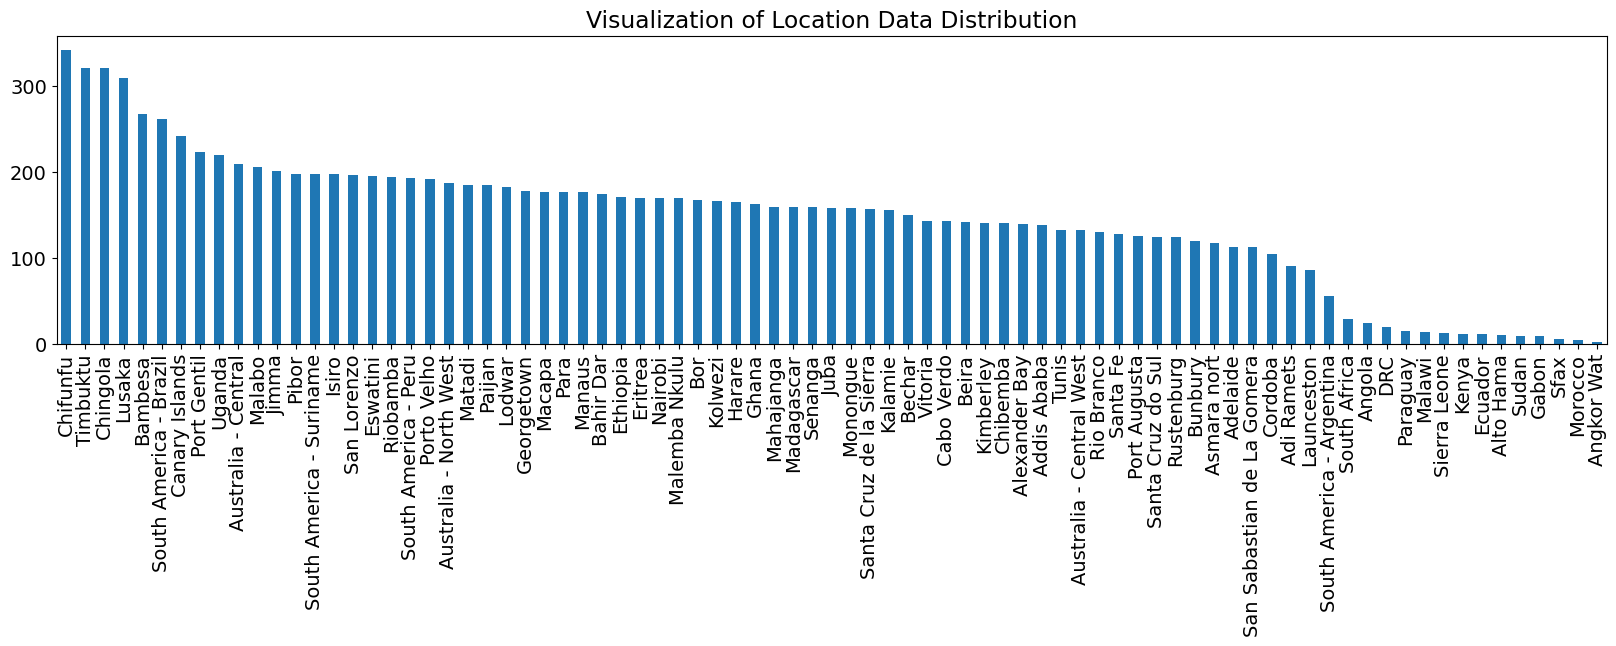

In [17]:
# Chart - 1  "Visualization of Location Data Distribution"

plt.figure(figsize=(20, 4))
df['location'].value_counts().plot.bar()
plt.title('Visualization of Location Data Distribution')
plt.show()

In [18]:
# top 5
df['location'].value_counts().head()

Chifunfu    341
Timbuktu    321
Chingola    321
Lusaka      309
Bambesa     267
Name: location, dtype: int64

In [19]:
# bottom 5
df['location'].value_counts().sort_values(ascending=True).head()

Angkor Wat    2
Morocco       4
Sfax          6
Gabon         9
Sudan         9
Name: location, dtype: int64

It is observed that most of the images were captured at location Chifunfi and least numbers were of angkor wat

#### Chart - 2

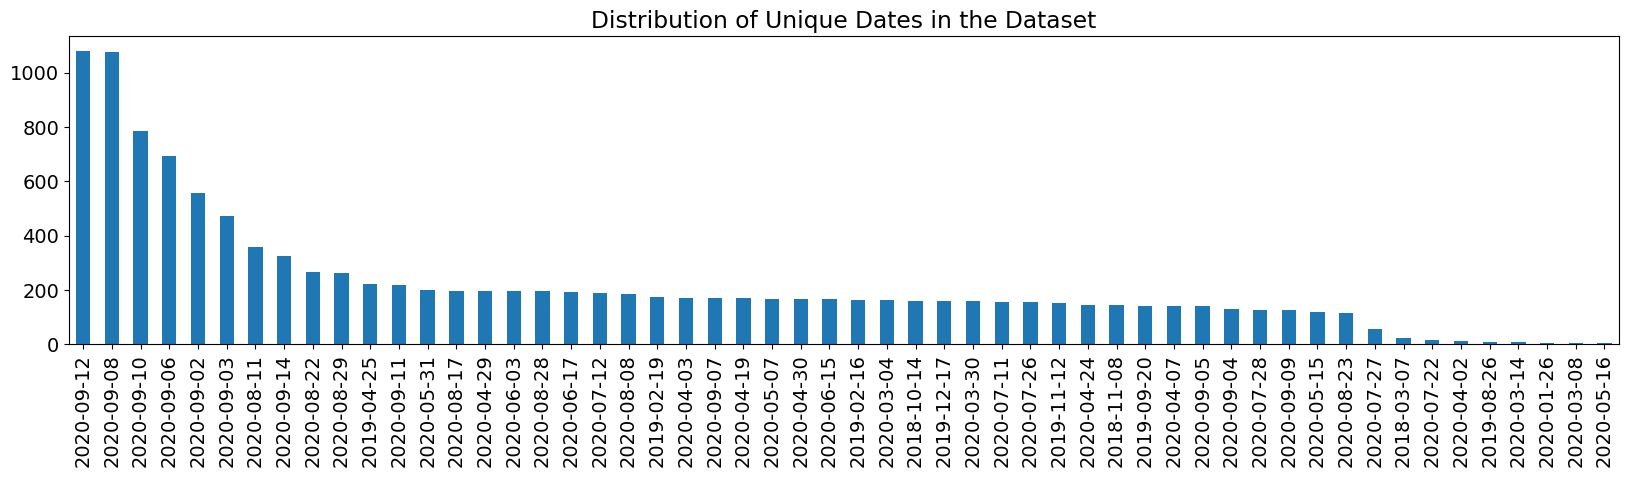

In [20]:
# Chart - 2 Distribution of Unique Dates in the Dataset
plt.figure(figsize=(20, 4))
df['date'].value_counts().plot.bar()
plt.title(f'Distribution of Unique Dates in the Dataset')
plt.show()

In [21]:
print("top 5 dates of most captured data")
df['date'].value_counts().head(5)

top 5 dates of most captured data


2020-09-12    1080
2020-09-08    1074
2020-09-10     783
2020-09-06     693
2020-09-02     555
Name: date, dtype: int64

In [22]:
# bottom 5
print("bottom 5 dates of most captured data")
df['date'].value_counts().sort_values(ascending=True).head(5)


bottom 5 dates of most captured data


2020-05-16    4
2020-03-08    6
2020-01-26    6
2020-03-14    9
2019-08-26    9
Name: date, dtype: int64

The mininmum number of data captured was 4 on 2020-05-16 and maximum was captured on 2020-09-12 that is 1080

####Chart-3

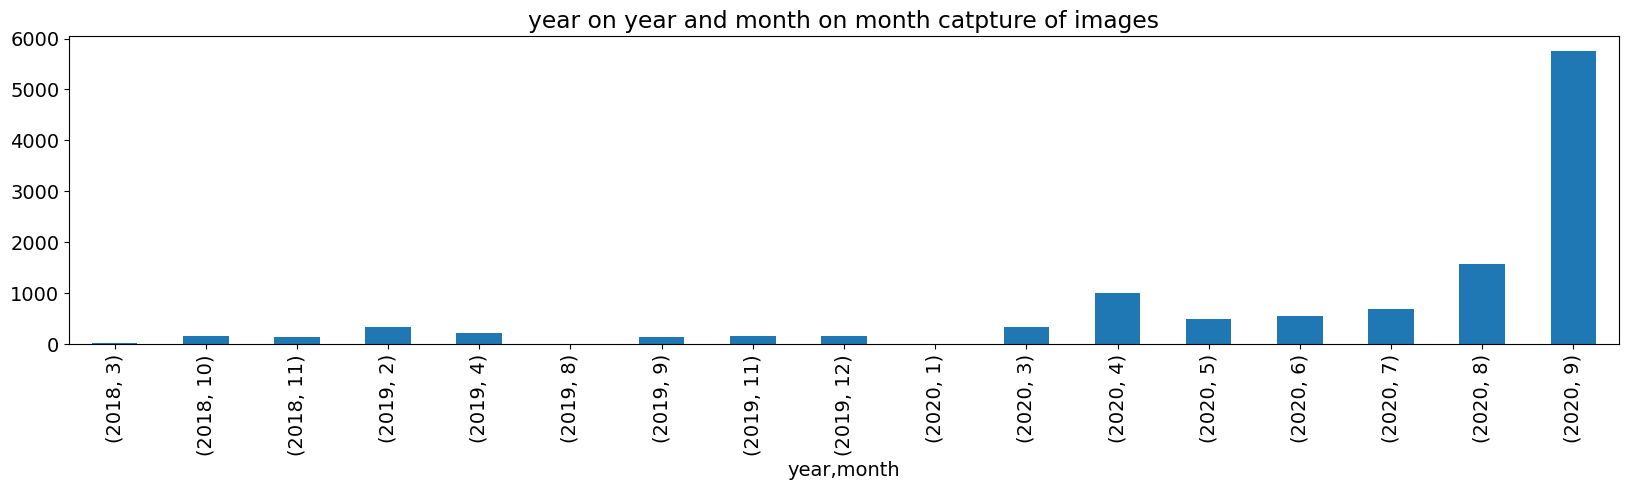

In [23]:
plt.figure(figsize=(20, 4))
df.groupby(['year', 'month']).month.count().plot(kind='bar', stacked=True)
plt.title(f'year on year and month on month catpture of images')
plt.show()

the graph shows the year on year number of captured rows.   
it is very evident that from march 2020 the data is captured more.

#### Chart - 4

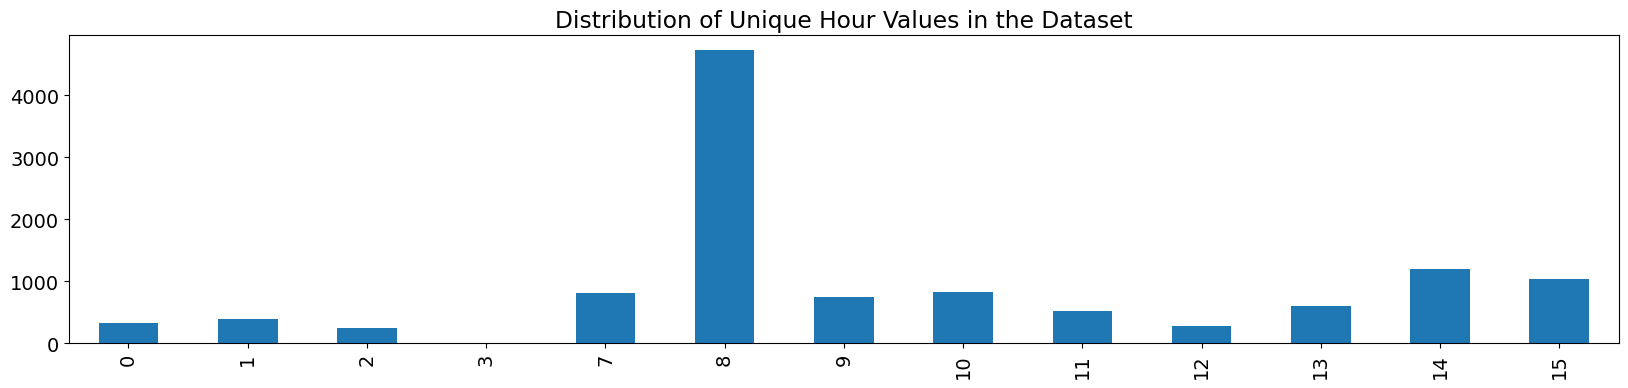

In [24]:
# Chart - 4 Distribution of Unique Hour Values in the Dataset
plt.rcParams['figure.figsize'] = (20,4)
df['hour'].value_counts().sort_index().plot(kind='bar')
plt.title(f'Distribution of Unique Hour Values in the Dataset')
plt.show()

In [25]:
print("Top 5 hours where most of the images were Taken")
df['hour'].value_counts().head(5)

Top 5 hours where most of the images were Taken


8     4733
14    1202
15    1039
10     827
7      810
Name: hour, dtype: int64

It is found post of the data is captured at 8am followed by 2pm amd 3 pm

#### Chart - 5

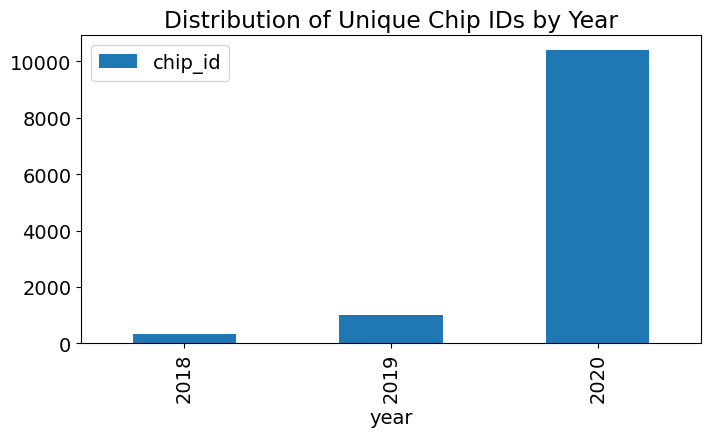

In [26]:
# Chart - 5 Distribution of Unique Chip IDs by Year
plt.rcParams['figure.figsize'] = (8,4)
df.groupby("year")[["chip_id"]].nunique().sort_index().plot.bar()
plt.title('Distribution of Unique Chip IDs by Year')
plt.show()

In [27]:
df.groupby("year")[["chip_id"]].nunique().sort_index(ascending = False).head()

chip_id
year         
2020    10407
2019     1015
2018      326

chart represents the number of images that were captured with respect to various years.

#### Chart - 6

<Axes: >

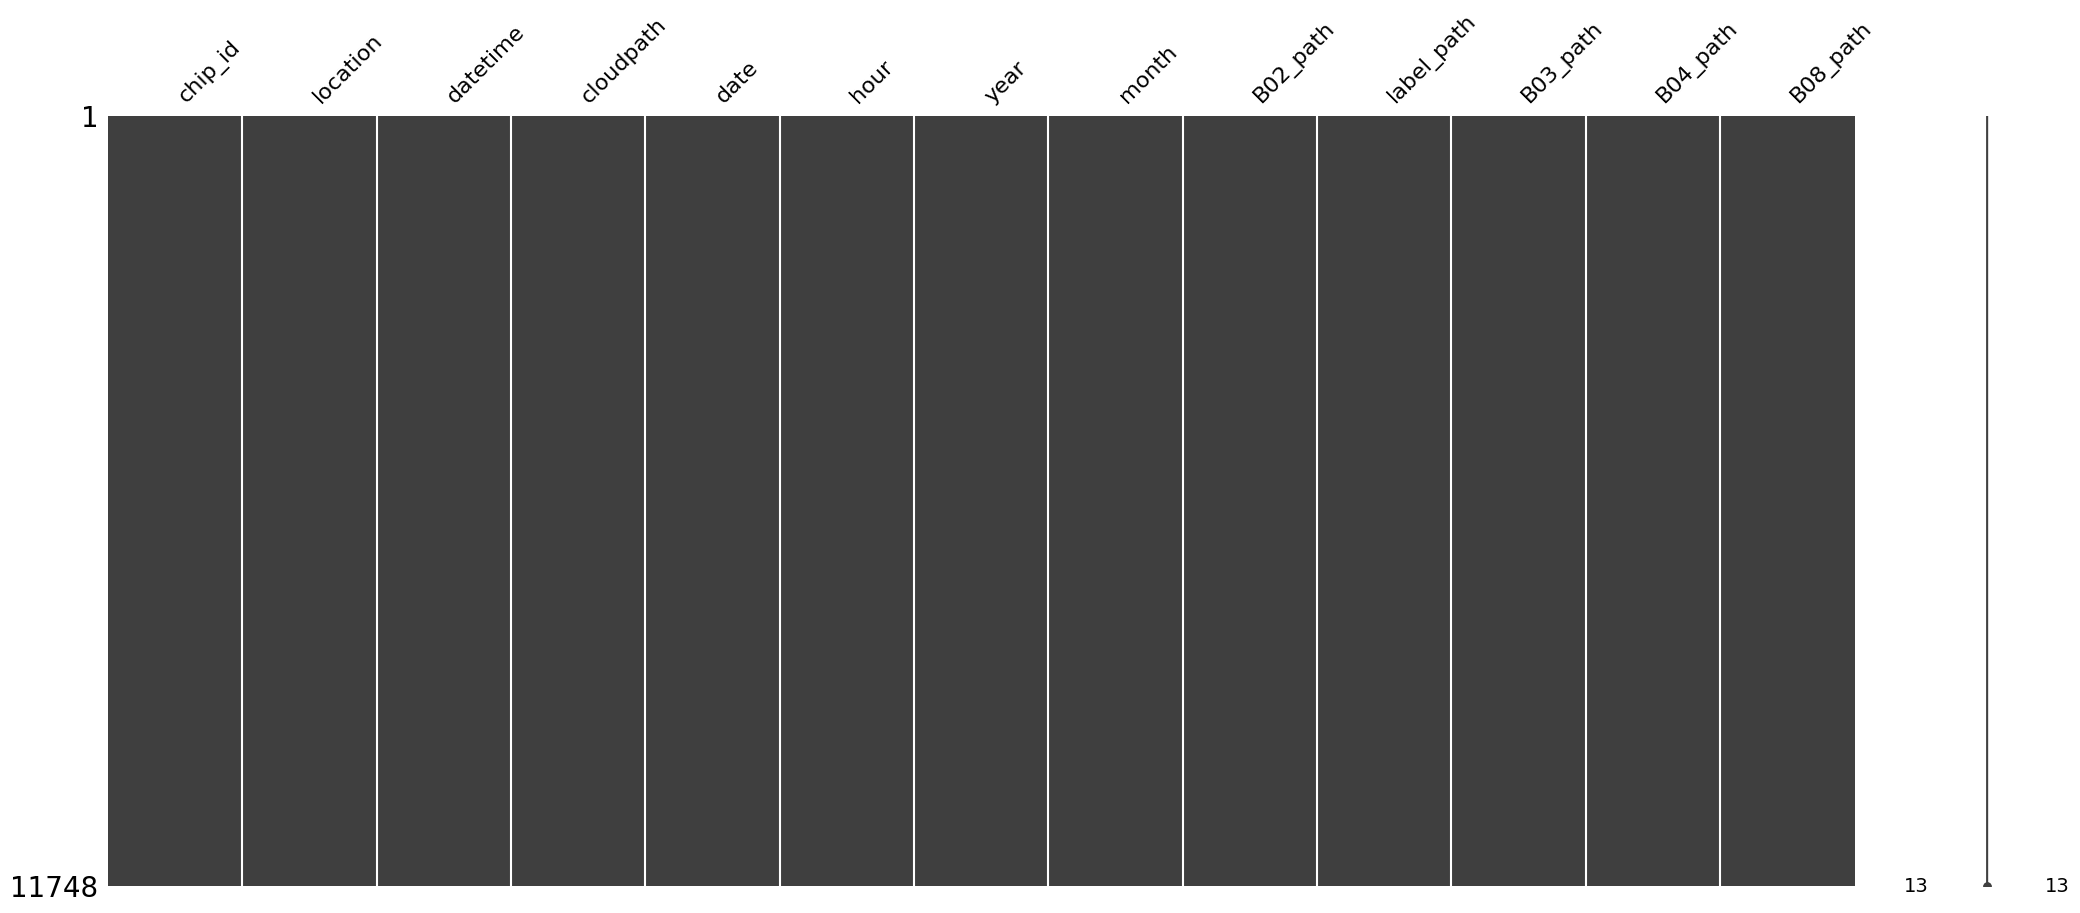

In [28]:
# Chart - 6 visualization code
# print(df.isna().sum())
# visualization of the df for missing values
msno.matrix(df)

No missing values are found.

#### Chart - 7

In [29]:
# Chart - 7 visualization code

# counting number of train features and files in the directories
print(f'Number of train features are {len(glob.glob("data/train_features/*"))}')
#
print(f'number of files prestent in each train features folders = {len(glob.glob("data/train_features/*/*"))}')

Number of train features are 11748
number of files prestent in each train features folders = 46992


In [100]:
len(glob.glob("data/train_features/*"))*len(img_bands) == len(glob.glob("data/train_features/*/*"))

True

It is found that the count of images in the train features and number of files in the folers are exactly 4 times more.


**It means all the lables have 4 images for the train feature.**

In [105]:
# checking in detail

if (len(glob.glob("data/train_features/*/B02.tif")) == len(glob.glob("data/train_features/*/B03.tif")) == len(glob.glob("data/train_features/*/B04.tif")) ==len(glob.glob("data/train_features/*/B08.tif"))):
  print(f'number of file with the bands B02, B03,B04 and B08 are equal that is {len(glob.glob("data/train_features/*/B02.tif"))}')
else:
  print('number of files are not equal')

number of file with the bands B02, B03,B04 and B08 are equal that is 11748


In [85]:
# taking a random sample to make further visualization wrt images and paths
sample_chip = df.sample(1).iloc[0]

In [84]:
# sample data look
sample_chip

chip_id                                            wjnh
location                                    Port Gentil
datetime                      2020-09-08 09:50:58+00:00
cloudpath                    az://./train_features/wjnh
date                                         2020-09-08
hour                                                  9
year                                               2020
month                                                 9
B02_path      /content/data/train_features/wjnh/B02.tif
label_path          /content/data/train_labels/wjnh.tif
B03_path      /content/data/train_features/wjnh/B03.tif
B04_path      /content/data/train_features/wjnh/B04.tif
B08_path      /content/data/train_features/wjnh/B08.tif
Name: 9694, dtype: object

#### Chart - 8

In [33]:
# Chart - 7 visualization code
# extracting metadata from the sample
with rasterio.open(sample_chip["B02_path"]) as img:
  chip_metadata = img.meta
  img_array = img.read(1)

chip_metadata

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': 0.0,
 'width': 512,
 'height': 512,
 'count': 1,
 'crs': CRS.from_epsg(32736),
 'transform': Affine(10.0, 0.0, 311795.0,
        0.0, -10.0, 6900365.0)}

#### Chart - 9

In [34]:
# getting Longitude and latitude of the sample chip
with rasterio.open(sample_chip["B02_path"]) as img:
  Longitude, Latitude = img.lnglat()
  # bounds = img.bounds
print(f"Longitude: {Longitude}, Longitude: {Latitude}")

Longitude: 31.111509719378017, Longitude: -28.032086988631043


#### Chart - 10

In [35]:
# getting shape of the sample image
band_paths = ['B02_path', 'B03_path', 'B04_path', 'B08_path']
for i in band_paths:
  with rasterio.open(sample_chip[i]) as img:
    img_array = img.read(1)
  band_name = i.split('_')
  print(f'Image array shape for Band {band_name[0]} is, {img_array.shape}')

Image array shape for Band B02 is, (512, 512)
Image array shape for Band B03 is, (512, 512)
Image array shape for Band B04 is, (512, 512)
Image array shape for Band B08 is, (512, 512)


#### Chart - 11

In [87]:
# sample_chip = df.sample(1).iloc[0]

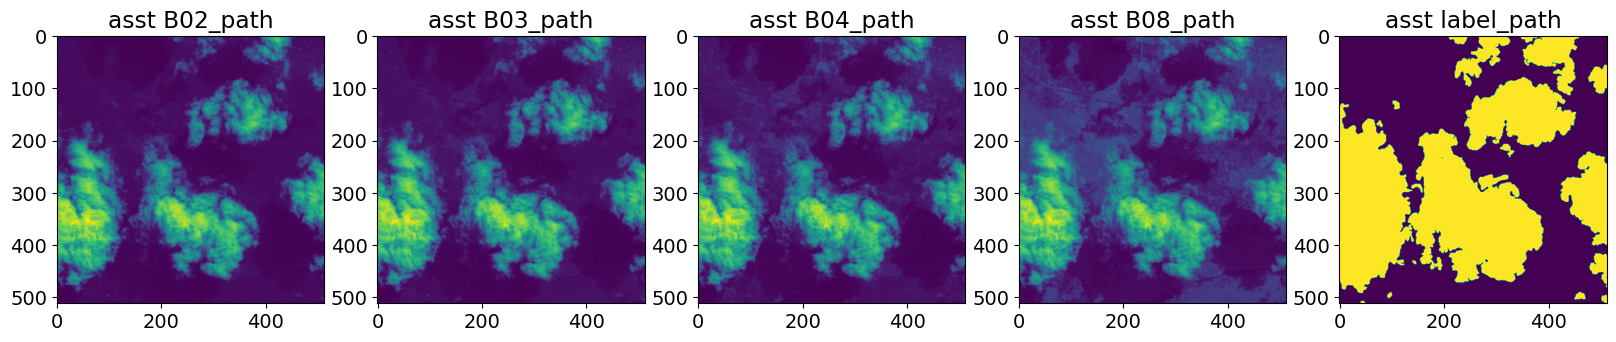

In [88]:
# ploting all the related files related to the example chip.
paths = ['B02_path', 'B03_path', 'B04_path', 'B08_path', 'label_path']
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for i, j in enumerate(paths):
  with rasterio.open(sample_chip[j]) as img:
    img_array = img.read(1)
    axes[i].imshow(img_array)
    axes[i].set_title(f'{sample_chip.chip_id} {j}')

plt.show()


#### Chart - 12

In [69]:
# Getting true color image of the sample chip
def get_xarray(filepath):
    im_arr = np.array(Image.open(filepath))
    return xarray.DataArray(im_arr, dims=["y", "x"])

def true_color_img(chip_id, data_dir= "/content/data/train_features/"):
  data_dir= "/content/data/train_features/"
  chip_dir = Path(data_dir) / chip_id
  red = get_xarray(chip_dir / "B04.tif")
  green = get_xarray(chip_dir / "B03.tif")
  blue = get_xarray(chip_dir / "B02.tif")

  return ms.true_color(r=red, g=green, b=blue)

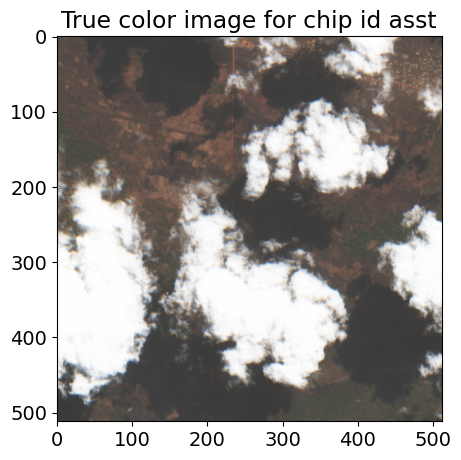

In [89]:
fig, ax = plt.subplots(figsize=(5, 5))
im = true_color_img(sample_chip.chip_id)
ax.imshow(im)
plt.title(f"True color image for chip id {sample_chip.chip_id}")
plt.show()

#### Chart - 13

In [90]:
# helper function for Displaying random chip and its label
def display_random_chip(random_state):
  """Displays a true color image and the corresponding label for that chip"""
  fig, ax = plt.subplots(1, 2, figsize=(8, 4))
  random_chip = df.sample(random_state=random_state).iloc[0]
  ax[0].imshow(true_color_img(random_chip.chip_id))
  ax[0].set_title(f"Chip {random_chip.chip_id}\n(Location: {random_chip.location})")
  label_im = get_xarray(random_chip.label_path)
  ax[1].imshow(label_im)
  ax[1].set_title(f"Chip {random_chip.chip_id} label")
  plt.show()

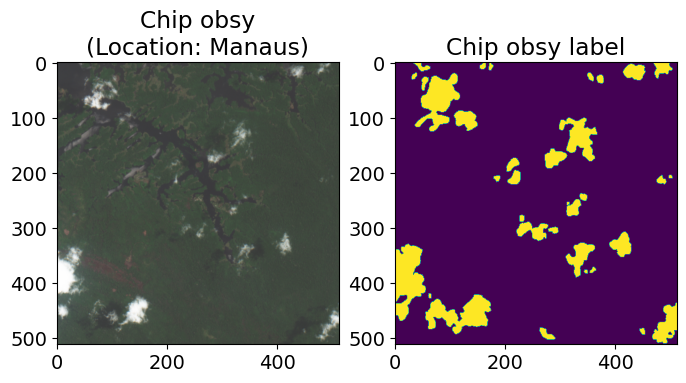

In [95]:
# displaying random chip and its label
display_random_chip(np.random.randint(df.shape[0]))

#### Chart - 14

In [96]:
def display_random_chip_bands(chip_id='none', random_state=1):
    """Displays a true color image, B02 band, B03 band, B04 band, B08 band and the corresponding label for chip"""
    fig, ax = plt.subplots(1, 6, figsize=(20, 10))
    if chip_id == 'none':
        chip_id = df.sample(random_state=random_state).iloc[0]
    else:
        chip_id = df.loc[df['chip_id'] == chip_id].iloc[0]
    true_color = true_color_img(chip_id.chip_id)
    ax[0].imshow(true_color)
    ax[0].set_title(f'{chip_id.chip_id} true color')

    for i, band in enumerate(img_bands, 1):
        datarray = get_xarray(f'/content/data/train_features/{chip_id.chip_id}/{band}.tif')
        ax[i].imshow(datarray)
        ax[i].set_title(f'{chip_id.chip_id} {band}')
    datarray = get_xarray(f'/content/data/train_labels/{chip_id.chip_id}.tif')
    ax[5].imshow(datarray)
    ax[5].set_title(f'{chip_id.chip_id} label, {round(float(datarray.mean().data), 2)}')

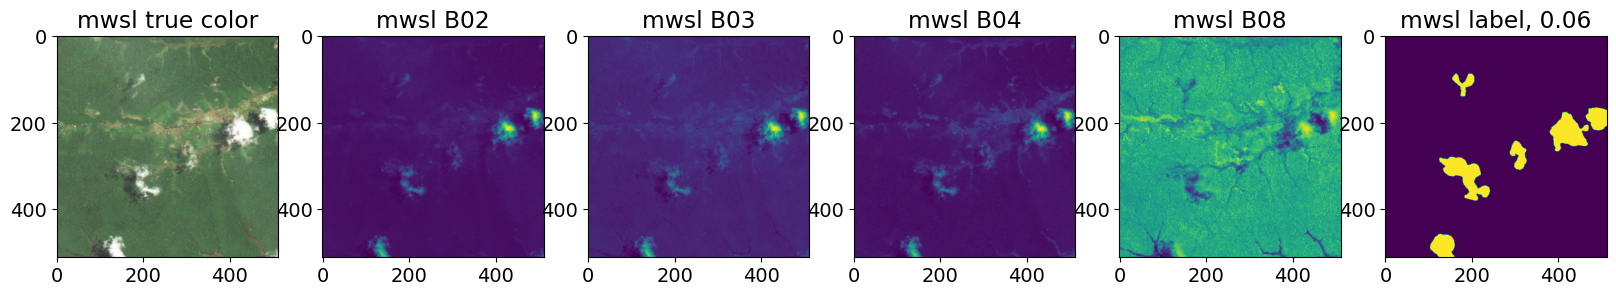

In [ ]:
# display_random_chip_bands(chip_id = 'valv', random_state = np.random.randint(df.shape[0]))
display_random_chip_bands(random_state = np.random.randint(df.shape[0]))



---



## ***Architecture Evaluation (pre), Literature Review:***

**Existing Methods:**  
The most widely accepted cloud semantic segmentation models are:
* SegNet
* PSPNet
* DeepLabV3
* UNet++ model

Based on literature review **DeepLabV3** and **UNet++** models are well suited for the given problem statement as the models are evaluated based on per pixel base.

more details on library:  
* [DeepLabV3](https://pytorch.org/hub/pytorch_vision_deeplabv3_resnet101/)  
* [UNet++](https://paperswithcode.com/method/unet)

---

examples of how model can be built for the given problem statment and dataset:   
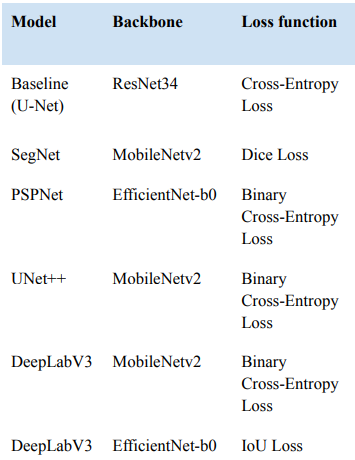

## ***Fine Tuning/Transfer Learning:***

Fine tuning for the problem statement can be done by the following apporaches:
* **Multi-Image Fusion**  
We apply multi-image fusion to take a stack of images over the same region, I = {I1, . . . , IK}, where Ij ∈ Rh×w×3 , and produce a fused image, F = φ(I), such that F is free of artifacts.  
There are two main steps:  
1) estimating a per-pixel quality mask for each image then using the qualities to compute a fused image   
2) passing the fused image through a segmentation network to produce a  per-pixel semantic labeling.  
When trained end-to-end, this architecture learns to estimate per-pixel image qualities that can be used to produce a fused image with reduced artifacts, without requiring explicit labels.

* **Detecting Clouds**  
The quality network learns to identify artifacts in the training data that negatively impact the final segmentation, for example clouds and regions of no data. We describe two approaches which use the quality network, trained for multiimage fusion, as a starting point for learning a cloud detector
(per-pixel binary classification)

Reference:  
[SINGLE IMAGE CLOUD DETECTION VIA MULTI-IMAGE FUSION](https://ieeexplore.ieee.org/abstract/document/9323759)

Link to paper: [SINGLE IMAGE CLOUD DETECTION VIA MULTI-IMAGE FUSION]( https://drive.google.com/file/d/15oz518H-x1BuxTiXvKdr60tTpK3fGExY/view?usp=sharing)

## ***Optimization:***

Neighboring pixels of remote sensing images can have lots
of similarities. As a consequence, classification could also
be performed at a region level, i.e., groups of similar pixels
are gathered together to form regions. The main advantage of this kind of approach is to gather statistics for similar pixels in order to make a reliable decision. Thus, group
level statistics are much less affected by the presence of
noise than pixel level statistics.

## ***Pseudo Code and Mathematical Explanation:***


Flowchart of GK-2A multitemporal cloud detection algorithm.  
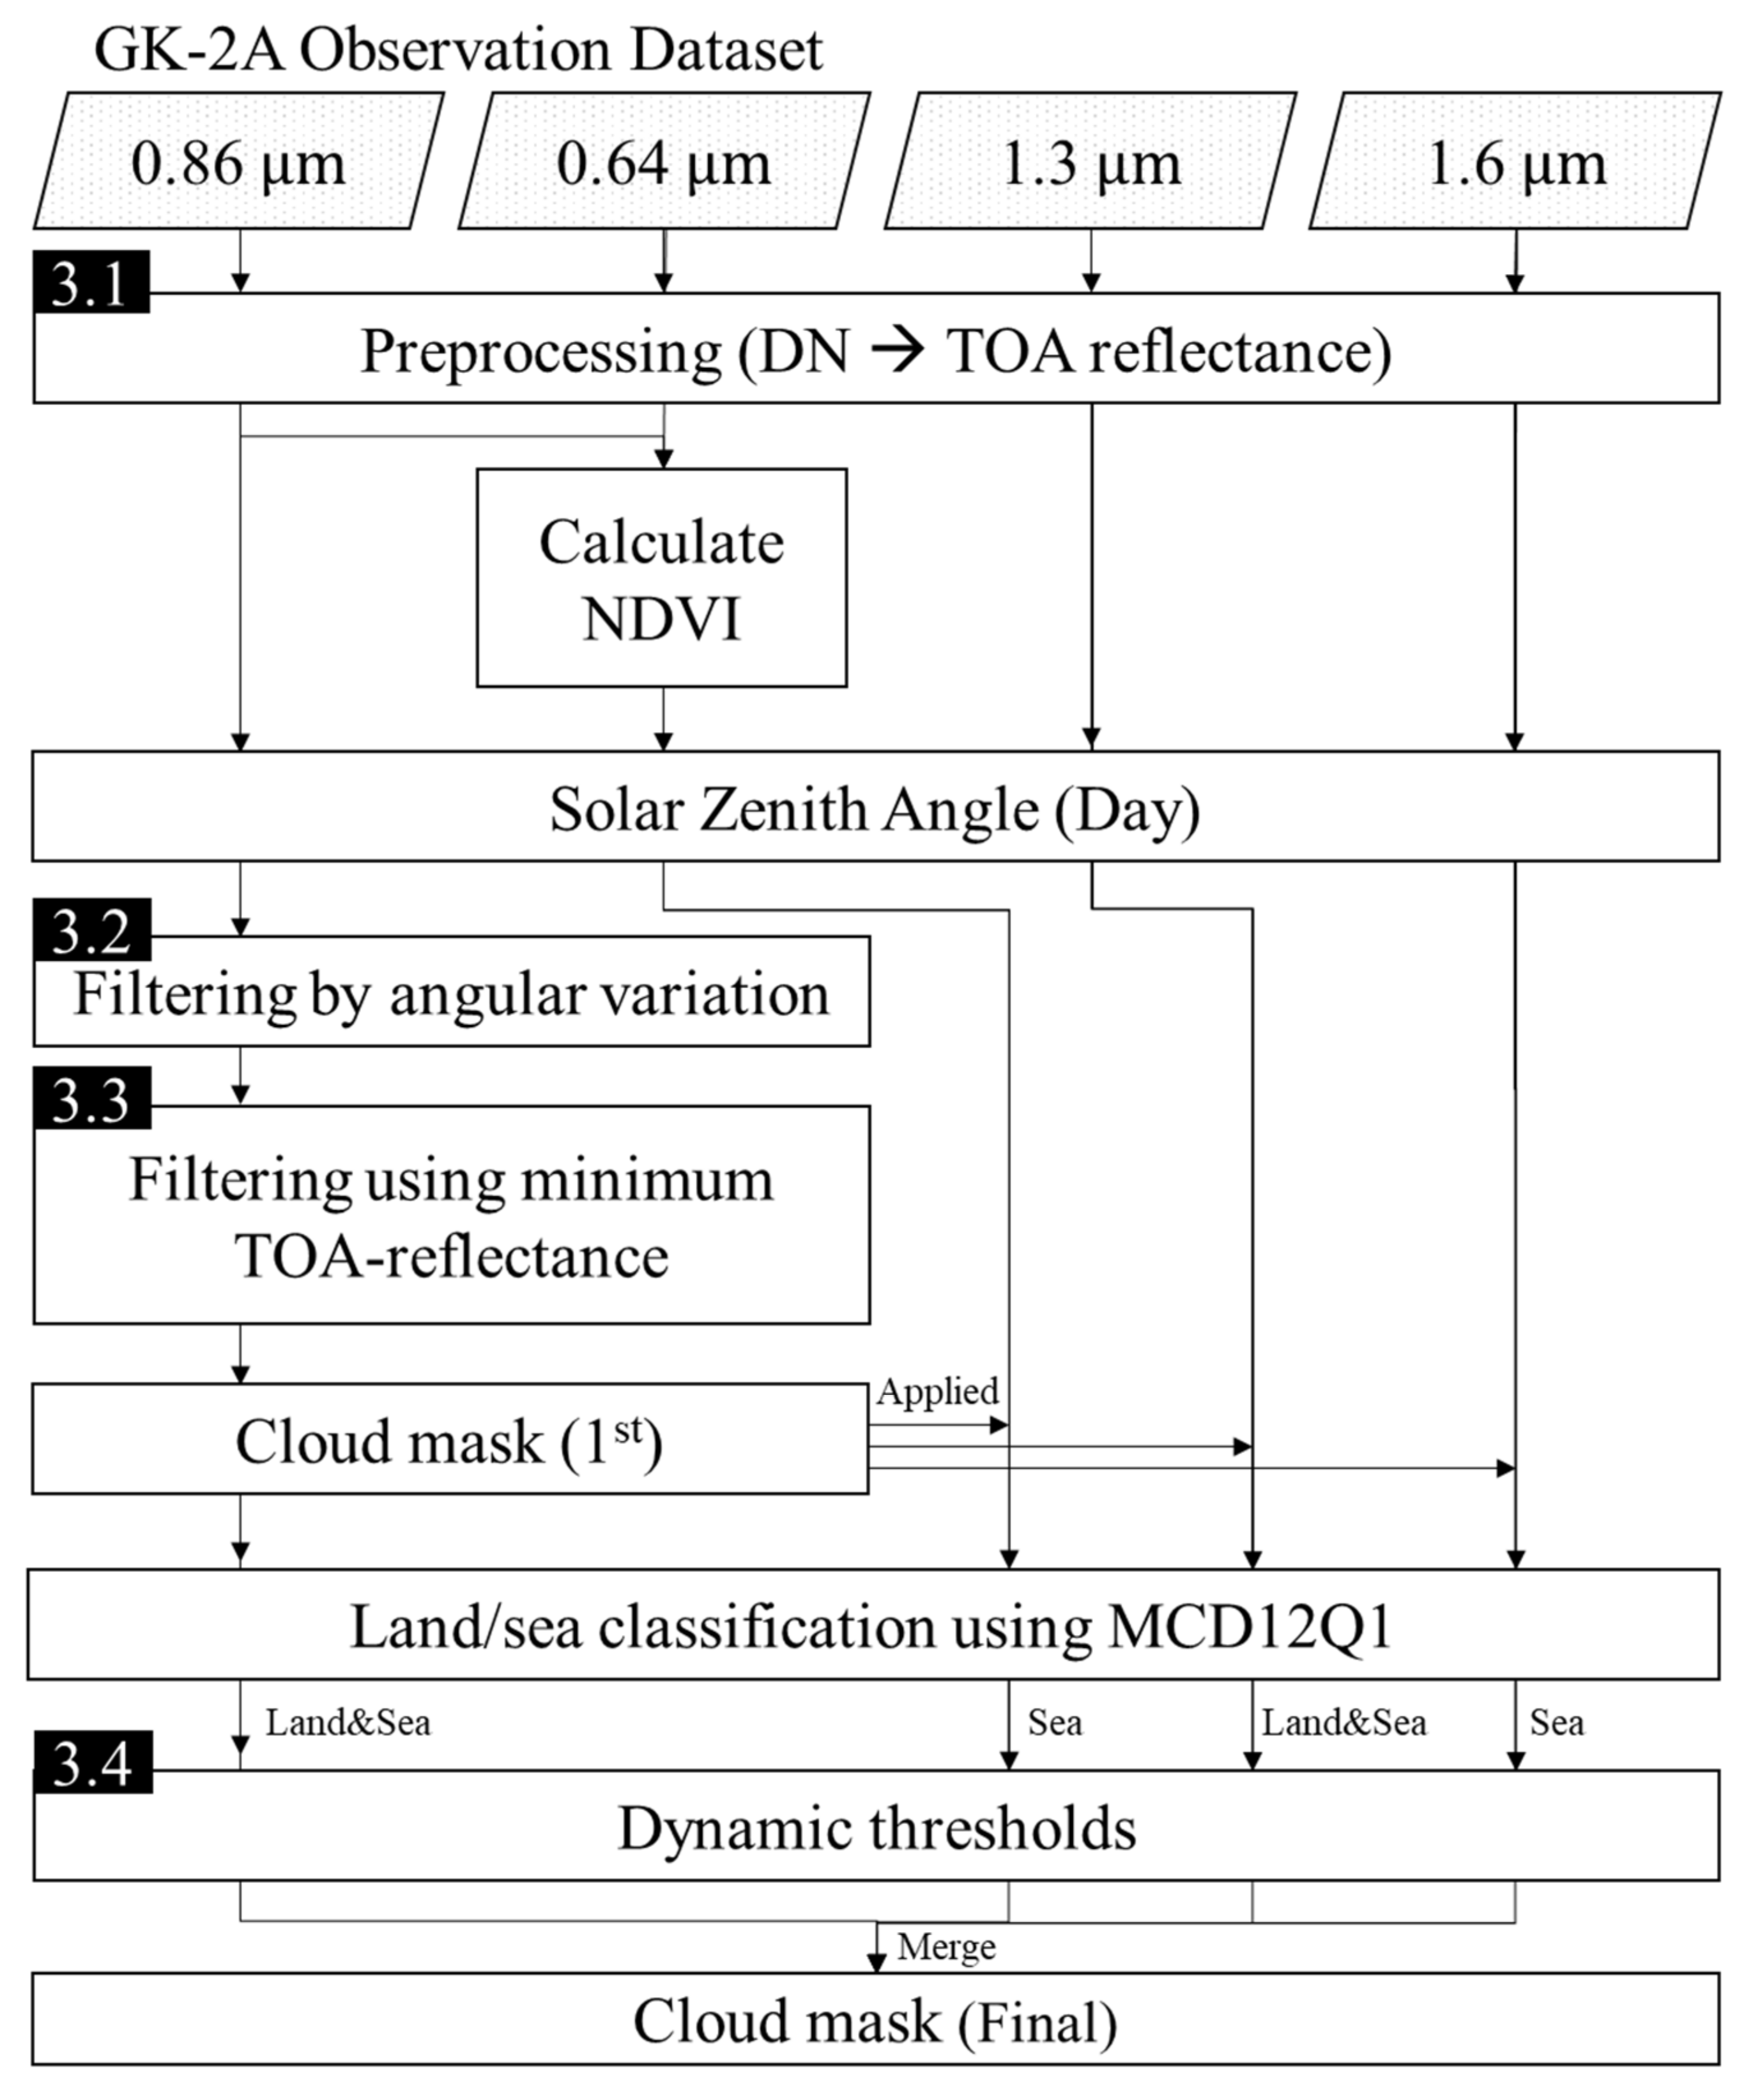

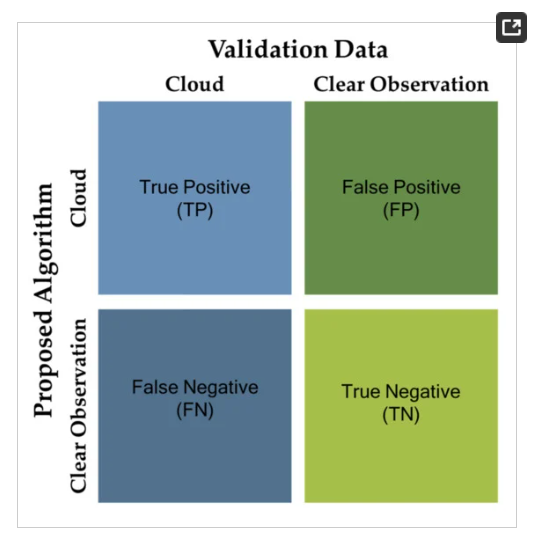



https://www.mdpi.com/2072-4292/13/16/3215

## ***Results and Discussion:***

Other reference papers and publications:  

[A review on deep learning techniques for cloud detection
methodologies and challenges](https://drive.google.com/file/d/1mIDu0kyllYUJQ--en2F5Rlb1bDStOuqS/view?usp=sharing)

link to springer: https://link.springer.com/article/10.1007/s11760-021-01885-7

[Deep Learning for Cloud Detection](https://drive.google.com/file/d/1pp_e7WUEQbMd3P8lMwehNsQSEJgHOCck/view?usp=sharing)

##Playground Area

In [ ]:
# this is playground area!
true_color_dir = '/content/data/true_color_dir/'
def megre_RGB_save_true_color_image(chip):
  required_data = df[df['chip_id'] == chip]





In [ ]:
df.head()

chip_id  location                  datetime                   cloudpath  \
0    adwp  Chifunfu 2020-04-29 08:20:47+00:00  az://./train_features/adwp   
1    adwu  Chifunfu 2020-04-29 08:20:47+00:00  az://./train_features/adwu   
2    adwz  Chifunfu 2020-04-29 08:20:47+00:00  az://./train_features/adwz   
3    adxp  Chifunfu 2020-04-29 08:20:47+00:00  az://./train_features/adxp   
4    aeaj  Chifunfu 2020-04-29 08:20:47+00:00  az://./train_features/aeaj   

         date  hour  year  month                                   B02_path  \
0  2020-04-29     8  2020      4  /content/data/train_features/adwp/B02.tif   
1  2020-04-29     8  2020      4  /content/data/train_features/adwu/B02.tif   
2  2020-04-29     8  2020      4  /content/data/train_features/adwz/B02.tif   
3  2020-04-29     8  2020      4  /content/data/train_features/adxp/B02.tif   
4  2020-04-29     8  2020      4  /content/data/train_features/aeaj/B02.tif   

                            label_path  \
0  /content/data/train_labels/adwp.tif   
1  /content/data/train_labels/adwu.tif   
2  /content/data/train_labels/adwz.tif   
3  /content/data/train_labels/adxp.tif   
4  /content/data/train_labels/aeaj.tif   

                                    B03_path  \
0  /content/data/train_features/adwp/B03.tif   
1  /content/data/train_features/adwu/B03.tif   
2  /content/data/train_features/adwz/B03.tif   
3  /content/data/train_features/adxp/B03.tif   
4  /content/data/train_features/aeaj/B03.tif   

                                    B04_path  \
0  /content/data/train_features/adwp/B04.tif   
1  /content/data/train_features/adwu/B04.tif   
2  /content/data/train_features/adwz/B04.tif   
3  /content/data/train_features/adxp/B04.tif   
4  /content/data/train_features/aeaj/B04.tif   

                                    B08_path  
0  /content/data/train_features/adwp/B08.tif  
1  /content/data/train_features/adwu/B08.tif  
2  /content/data/train_features/adwz/B08.tif  
3  /content/data/train_features/adxp/B08.tif  
4  /content/data/train_features/aeaj/B08.tif

In [ ]:
from PIL import Image
import numpy as np
import os

In [ ]:
true_color_dir = '/content/data/true_color_dir/'
c_id = 'mwsl'

In [ ]:
required_data = df[df['chip_id'] == 'adwp']
blue = Image.open(required_data['B02_path'].values[0])
green = Image.open(required_data['B03_path'].values[0])
red = Image.open(required_data['B04_path'].values[0])
# Image.open
blue_array = np.array(blue)
green_array = np.array(green)
red_array = np.array(green)
composite_image = Image.new('RGB', blue.size)
composite_image.putdata(list(zip(red_array.flatten(), green_array.flatten(), blue_array.flatten())))

os.makedirs(true_color_dir, exist_ok=True)
composite_image.save(true_color_dir + str(c_id) +".tif")
path_to_file = true_color_dir + str(c_id)+ ".tif"

In [ ]:
def get_xarray(filepath):
  im_arr = np.array(Image.open(filepath))
  return xarray.DataArray(im_arr, dims=["y", "x"])


def true_color_img(chip_id, data_dir="/content/data/true_color_dir/izmo"):
  chip_dir = Path(data_dir)
  red = get_xarray(chip_dir / "B04.tif")
  green = get_xarray(chip_dir / "B03.tif")
  blue = get_xarray(chip_dir / "B02.tif")

  return ms.true_color(r=red, g=green, b=blue)

In [ ]:
from rasterio.plot import show

In [ ]:
path_to_file = '/content/data/true_color_dir/mwsl.tif'

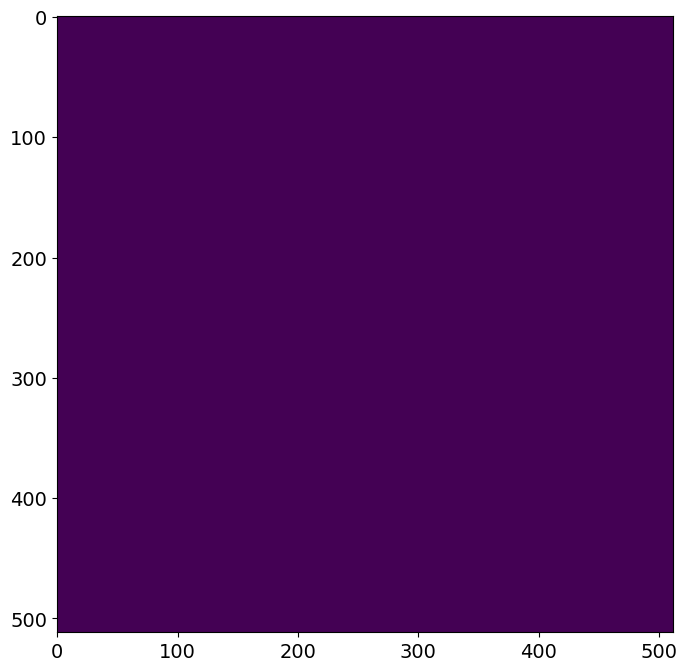

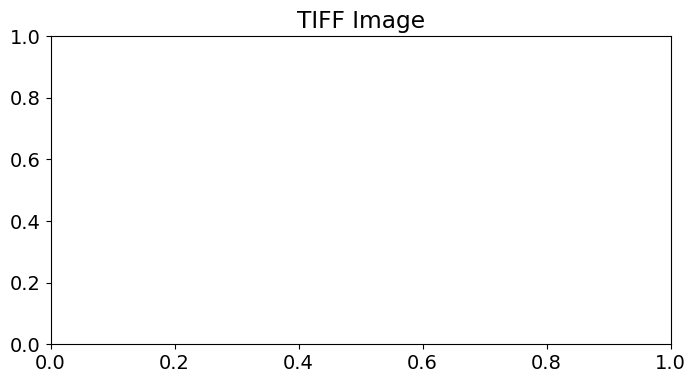

In [ ]:
with rasterio.open(path_to_file) as src:
    # Read the image data
    img = src.read(1)  # You can specify the band number you want to read

# Plot the image using matplotlib
plt.figure(figsize=(8, 8))
show(img, cmap='viridis')  # 'cmap' sets the colormap for visualization
plt.title('TIFF Image')
plt.show()

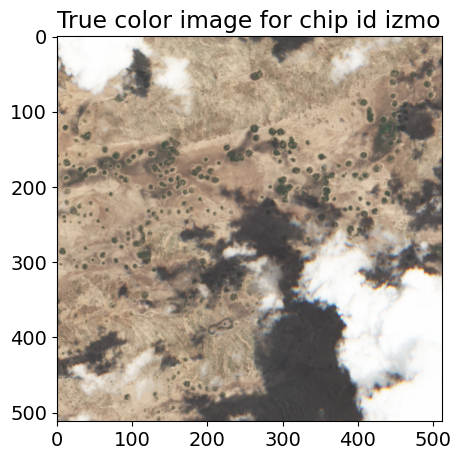

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
im = true_color_img(sample_chip.chip_id)
ax.imshow(im)
plt.title(f"True color image for chip id {sample_chip.chip_id}")
plt.show()

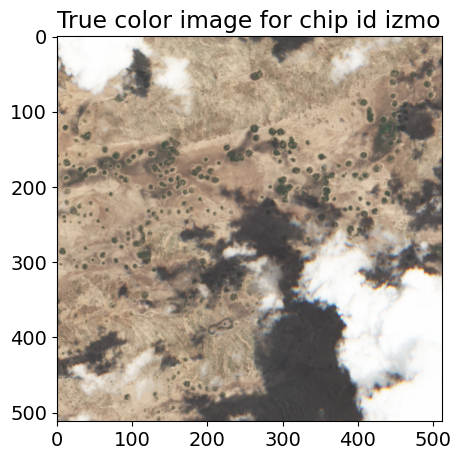

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
im = true_color_img(sample_chip.chip_id)
scaled_im = im.copy()
ax.imshow(scaled_im)
plt.title(f"True color image for chip id {sample_chip.chip_id}")
plt.show()

In [ ]:
path_to_file

'/content/data/true_color_dir/adwp.png'

In [ ]:
required_data

chip_id  location                  datetime                   cloudpath  \
0    adwp  Chifunfu 2020-04-29 08:20:47+00:00  az://./train_features/adwp   

         date  hour  year  month                                   B02_path  \
0  2020-04-29     8  2020      4  /content/data/train_features/adwp/B02.tif   

                            label_path  \
0  /content/data/train_labels/adwp.tif   

                                    B03_path  \
0  /content/data/train_features/adwp/B03.tif   

                                    B04_path  \
0  /content/data/train_features/adwp/B04.tif   

                                    B08_path  
0  /content/data/train_features/adwp/B08.tif